# Thinking Non-Linearly about the Effective AoA of a FWTD

Within all the current linear analysis of FWTD's the following equations have been used to describe the change in AoA of the FWT with respect to the flare and fold angle:

$\Delta\alpha_h(\Lambda,\theta) = -\arctan(\tan{\theta} \sin{\Lambda}$)

where $\theta$ is the fold angle and $\Lambda$ is the flare angle

This is derived using small angle approximations. By considering this equation at some critical location we can highlight so of the major flaws of this equation:

### Fold Angle of 90 Degrees

$\theta = \frac{\pi}{2},  \Delta\alpha_h(\Lambda) = \infty$

This is obviously incorrect, and from inspection of the geomtry it is clear that at $\alpha \ne 0$

### Flare Angle of 0 Degrees

$\lim_{\Lambda \to 0} \Delta\alpha_h(\gamma,\theta) = 0$

Or more over the AoA of the FWT is not a function of theta if there is no flare angle.

This again can be disproven by considering a wing at the initial conditions:

$\alpha = \alpha_r, \Lambda = \theta = 0$

In this condition the AoA of the FWT must be the AoA of the main wing, $\alpha_r$. However, when you then rotate theta up to $\pm\frac{\pi}{2}$ the AoA of the FWT tends to ZERO! 

$\theta = \pm\frac{\pi}{2}, \Lambda = 0, \alpha_h = 0 $

i.e. $\Delta\alpha_h$ is a function of $\alpha_r$

# So What is the Equation for $\Delta\alpha_h$ ?

What is clear is that $\Delta\alpha_h = f(\alpha_r,\Lambda,\theta)$

To find what this function is we will use rotation matrices to go from the 'Velocity Frame of Reference' to the 'Hinge Frame of Reference'. For completeness we will also consider the effect of yawslip, e.g. $\gamma$. Hence $\Delta\alpha_h = f(\alpha_r,\Lambda,\theta, \gamma)$

In the Velocity frame of refernce the velocity vector is:

$\mathbf{V} = \begin{bmatrix}u\\0\\0\end{bmatrix}$ 

where $u$ is the velocity magnitude. The aim is to translate this vector into the 'hinge reference frame' in which
1. $y$ runs along the leading edge of the FWT
2. $x$ runs along the chord line of the FWT

### Preamble

In [66]:
import sympy as sym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
## a/c to wind transform
alpha,beta = sym.symbols(['alpha','beta'])
V_Ac = sym.rot_axis2(-alpha)*sym.rot_axis3(-beta)  # transform from a/c to the velocity frame 
Ac_V = V_Ac**-1                                    # transform from velocity frame to a/c


## a/c to Hinge transform
Lambda,theta = sym.symbols(['Lambda','theta'])


H_Ac = sym.trigsimp(sym.rot_axis3(-Lambda)*\
                    sym.rot_axis1(theta)*  \
                    sym.rot_axis3(Lambda))        # transform from a/c to the hinge frame 


H_V = sym.trigsimp(H_Ac*Ac_V)                      # transform from velocity to hinge reference frame

# Velocity vector in velocity frame is of the form [v 0 0]
u = sym.Symbol('u')
Vv = sym.Matrix([u,0,0])

# Transform into the hinge reference frame
Vh = H_V * Vv

f = sym.lambdify((alpha,beta,Lambda,theta,u),Vh)
Vh

Matrix([
[           u*(-sin(Lambda)*sin(alpha)*sin(theta) + sin(Lambda)*sin(Lambda + beta)*cos(alpha)*cos(theta) - sin(Lambda)*sin(Lambda + beta)*cos(alpha) + cos(alpha)*cos(beta))],
[u*(-sin(Lambda)*cos(alpha)*cos(theta)*cos(Lambda + beta) + sin(Lambda)*cos(alpha)*cos(Lambda + beta) + sin(alpha)*sin(theta)*cos(Lambda) - sin(beta)*cos(alpha)*cos(theta))],
[                                                                                                       u*(sin(alpha)*cos(theta) + sin(theta)*sin(Lambda + beta)*cos(alpha))]])

That is quite complex. Lets explore this vector a little bit....

Below I am going to calculate this velocity vector for multiple instances of each of the variables, we will then explore the parameter space.

Note, if we call the above vector $V^h$ and its components $v_N^h,for N=0,1,2$ then:

$\Delta\alpha_h = \arctan{\frac{v_2^h}{v_0^h}}-\alpha$
$\Delta\beta_h = \arctan{\frac{v_1^h}{v_0^h}}-\beta$

and importantly the effective velocity changes as well (call $u_h$ the magnitude of the flow perp to the FWT's LE):

$u_h = \sqrt{(v_0^h)^2+(v_2^h)^2}$

This is assuming the cross flow has a negligable effect on the aerodynamics...


In [73]:
AoAs = np.linspace(-10,10,9)
Thetas = np.linspace(-135,135,55)
Lambdas = np.linspace(-25,25,11)
Betas = np.linspace(-25,25,11)

dat = []

for i in AoAs:
    for j in Thetas:
        for k in Lambdas:
            for w in Betas:
                dat.append([i,j,k,w,f(np.deg2rad(i),np.deg2rad(w),np.deg2rad(k),np.deg2rad(j),1).T])
df = pd.DataFrame(data = dat,columns=['Alpha','Theta','Lambda','Beta','V'])
# print(df.head())
df[['v1','v2','v3']] = df['V'].apply(lambda x: pd.Series(x[0]) )
df['Alpha_h'] = np.rad2deg((df['v3']/df['v1']).apply(np.arctan))
df['DeltaAlpha_h'] = df['Alpha_h']-df['Alpha']
df['Beta_h'] = np.rad2deg((df['v2']/df['v1']).apply(np.arctan))
df['DeltaBeta_h'] = df['Beta_h']-df['Beta']
df['u_h'] = np.sqrt(df['v3']*df['v3'] + df['v1']*df['v1'])
# print(df.head())
# #df['Sweep_h'] = (df['v3']/df['v1']).apply(np.arctan)  
df = df.drop(labels='V',axis=1)

## Effect of AoA for $\Lambda = 0$

First lets plot some of the relationships decribed at the top to validate the formula.

For each AoA we should expect to see $\alpha_h \to 0$ as $\theta \to 90$, for $\Lambda = 0$

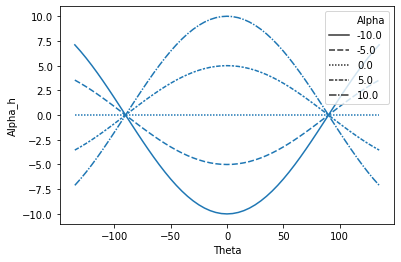

In [74]:
d = df[(pd.Series((np.isin(df['Alpha'],[10,5,0,-5,-10])))) & (df['Lambda']==0) & (df['Beta']==0)]

sns.lineplot(data = d,x='Theta',y='Alpha_h',style = 'Alpha')

## Effect of Lambda and Theta @ Alpha = 0

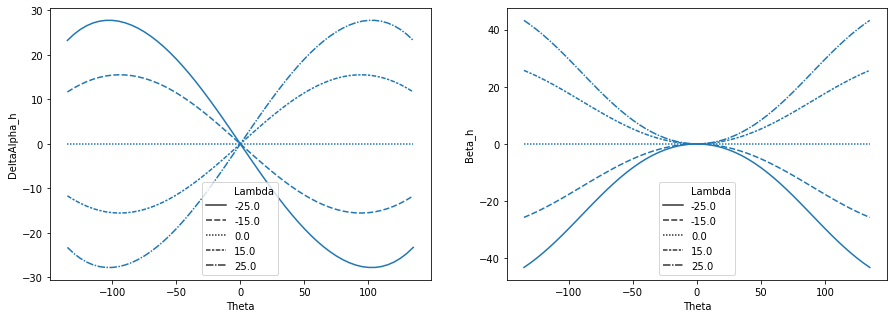

In [94]:
d = df[(pd.Series((np.isin(df['Lambda'],[-25,-15,0,15,25])))) & (df['Alpha']==0) & (df['Beta']==0)]
fig, axes = plt.subplots(1,2,figsize=(15,5))
ax = sns.lineplot(data = d,x='Theta',y='DeltaAlpha_h',style='Lambda',ax=axes[0])
ax = sns.lineplot(data = d,x='Theta',y='Beta_h',style='Lambda',ax=axes[1])

# ax.set(grid = True)

Some interesting thigs from this:
1. the maximum alpha_h does not occur at 90 degrees
2. the maximum shifts with Lambda

Assuming everything else is constant how does the lift vary?

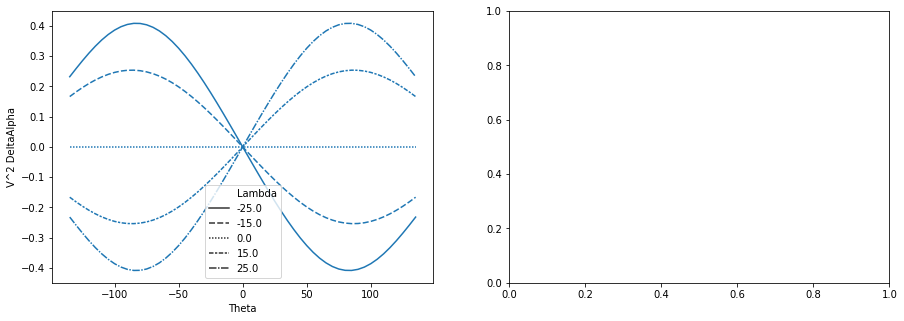

In [130]:
df['V^2 DeltaAlpha'] = df['u_h']*df['u_h']*np.deg2rad(df['DeltaAlpha_h'])

d = df[(pd.Series((np.isin(df['Lambda'],[-25,-15,0,15,25])))) & (df['Alpha']==0) & (df['Beta']==0)]

fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(data = d,x='Theta',y='V^2 DeltaAlpha',style='Lambda',ax=axes[0])

The maximum moves closer to 0 degrees Theta

## Take the Case of the WTT model ($\Lambda = -10^o$)

How does varying the AoA vary the plot above?

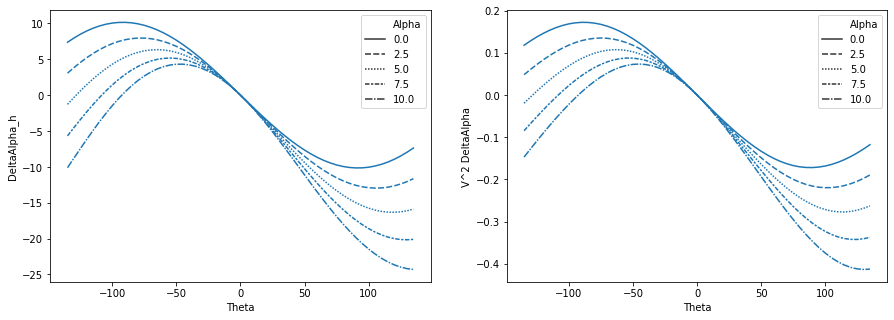

In [131]:
d = df[(pd.Series((np.isin(df['Alpha'],[0,2.5,5,7.5,10])))) & (df['Lambda']==-10) & (df['Beta']==0)]

fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(data = d,x='Theta',y='DeltaAlpha_h',style='Alpha',ax=axes[0])
sns.lineplot(data = d,x='Theta',y='V^2 DeltaAlpha',style='Alpha',ax=axes[1])

At $AoA=10$ your maximum lift is achieved at ~-45 degrees and is a less than 5 degrees variation on your starting angle

In the WTT the maximum hinge angles achieved were $20 \to -30$ degrees, at 10 degrees how different are the predictions compared to the linear model?

[(-5, 5), (-10, 10)]

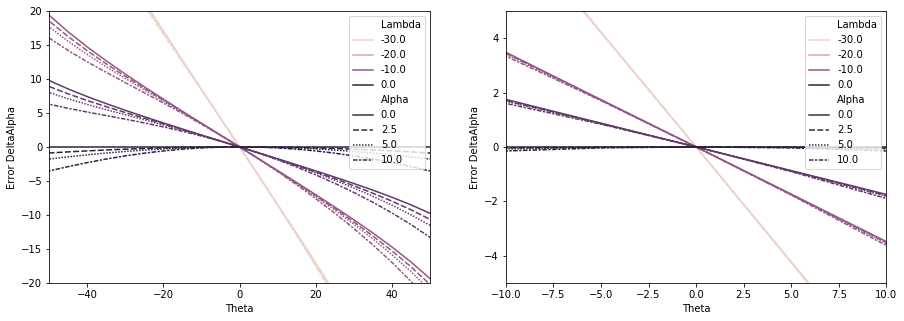

In [152]:
df['Linear DeltaAlpha'] =np.rad2deg(-np.arctan(np.tan(np.deg2rad(df['Theta']))*np.sin(np.deg2rad(df['Lambda']))))
df['V^2 Linear DeltaAlpha'] = np.deg2rad(df['Linear DeltaAlpha'])

df['Error DeltaAlpha'] = df['DeltaAlpha_h']-df['Linear DeltaAlpha']
fig, axes = plt.subplots(1,2,figsize=(15,5))
d = df[(pd.Series((np.isin(df['Alpha'],[0,2.5,5,10])))) & (pd.Series((np.isin(df['Lambda'],[0,-5,-10,-25])))) & (df['Beta']==0)]
sns.lineplot(data = d,x='Theta',y='Error DeltaAlpha',style='Alpha',hue='Lambda',ax=axes[0])
sns.lineplot(data = d,x='Theta',y='Error DeltaAlpha',style='Alpha',hue='Lambda',ax=axes[1])
axes[0].set(xlim=(-50,50),ylim=(-20,20))
axes[1].set(xlim=(-10,10),ylim=(-5,5))
#axes[0].legend(["Non-linear Model","Linear Model"])
#axes[1].legend(["Non-linear Model","Linear Model"])



At zero degrees AoA the error is small, however even for a small AoA (2.5) you get 2 degrees of error over +/-10 theta!


these effects actually make quite a large difference even within the region we tested / at small angles during the WTT

can I fit the steady case data better with this new model???